# TP1 Deep QLearning

Dans ce TP, l'objectif est d'impl√©menter un agent apprenant √† faire atterir un vaisseau sur la lune avec l'algorithme Deep Q-Network. Pour cela vous allez utiliser [PyTorch](https://pytorch.org/) et [Gymnasium](https://gymnasium.farama.org/). 

<img src='img/lunarlander.png'  width=500px>

# 1. Consignes

> <span style="color:red">Compl√©ter ce notebook et les diff√©rents fichiers python associ√©s</span>.  
> 
>  <span style="color:red">R√©pondre aux questions</span> (dans les cellules <span style="color:blue">Votre r√©ponse: </span> )


> Le code doit √™tre fonctionnel avec l'environnement virtuel du TP. Si d'autres packages que ceux pr√©sents dans l'environnement virtuel cr√©√© au d√©part sont n√©cessaires, vous devez ajouter √† votre d√©p√¥t un fichier `environnement.yaml` qui est un export de votre environnement virtuel. Ce fichier est obtenu avec la commande suivante:  ```conda env export > environnement.yaml```



# 2. Import des packages

In [1]:
import gymnasium as gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload

def init_seed(seedval):
    torch.manual_seed(seedval)
    np.random.seed(seedval)
    random.seed(seedval)

# 3. Gymnasium

En apprentissage par renforcement, il y a deux concepts fondamentaux : l‚Äôagent et l‚Äôenvironnement.
- L‚Äôagent est l‚Äôentit√© apprenante qui observe l‚Äôenvironnement et agit sur celui-ci selon les actions disponibles. Son objectif est de maximiser la r√©compense cumul√©e qu‚Äôil recoit de l‚Äôenvironnement avec lequel il interagit.
- L'agent interagit avec l'environnement √† travers la boucle de perception/action ce qui n√©cessite de d√©finir :
    - Un espace d‚Äôaction.
    - Un espace d‚Äô√©tat (ou observation).
    - Une fonction de r√©compense.
  
[Gymnasium](https://gymnasium.farama.org/) propose une interface open source unifi√©e entre un agent et un environnement.
- [Gymnasium](https://gymnasium.farama.org/) propose un ensemble d'environnements pour des t√¢ches d'apprentissage par renforcement. La plupart des environnements ont leur code source disponible sur [GitHub](https://github.com/Farama-Foundation/Gymnasium/tree/main/gymnasium/envs). De nouveaux environnements peuvent aussi √™tre cr√©√©s √† condition qu'ils soient compatibles avec l'interface. 
- Gr√¢ce √† l'interface unifi√©e, il est possible de d√©finir ind√©pendamment un agent de l‚Äôenvironnement avec lequel il interagit (et inversement). 
- Lorsque certains pr√©-traitements sont n√©cessaires sur les actions, observations, r√©compenses, ... il est possible d‚Äôencapsuler l‚Äôenvironnement dans un **wrapper**, celui-ci se chargera du pr√©-traitement. 




>  <span style="color:green">Documentation de Gymnasium</span>: [utilisation basique](https://gymnasium.farama.org/content/basic_usage/), [API pour les environnements](https://gymnasium.farama.org/api/env/), ...




##  3.1 - Caract√©ristiques de l'environnement LunarLander

Dans ce TP, nous allons impl√©menter un agent qui interagira avec l'environnement **LunarLander**, pr√©sent√©  [ici](https://gymnasium.farama.org/environments/box2d/lunar_lander/) et le code source est [ici](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py). 2 versions de LunarLander existent: avec des actions discr√®tes ou des actions continues.

> <span style="color:green">Quelle version choisir pour utiliser le DQN ? Pourquoi ? 



> <span style="color:blue">Votre r√©ponse: </span>
Dans notre cas, on utilisera la version avec des actions discr√®tes puisqu'on aura besoin pour estimer la valeur Q pour chaque action possible √† partir d'un √©tat donn√©. Pour utiliser le DQN, il faut alors choisir un environements √† espaces d'actions discret ou finis.

Il existe plusieurs fonctions cl√©s pour interagir avec un environnement Gymnasium ( [utilisation basique](https://gymnasium.farama.org/introduction/basic_usage/) et [API](https://gymnasium.farama.org/api/env/)).


> <span style="color:green">Compl√©ter la cellule de code ci-dessous pour afficher:
> 
> - **les dimensions pour les espaces d'√©tats et d'actions** de l'environnement `LunarLander`.
> - les bornes min et max pour les dimensions de l'√©tat
> - un √©chantillon pris au hasard dans chaque espace. 

In [2]:
env = gym.make("LunarLander-v3")

#TODO
print("Dimensions pour les espaces d'actions: " + str(env.action_space))
print("Dimensions pour les espaces d'√©tats: " + str(env.observation_space.shape))
print("Les bornes max des √©tats: " + str(env.observation_space.high))
print("Les bornes min des √©tats: " + str(env.observation_space.low))
print("Un √©chantillon al√©atoire de l'espace d'√©tats: " + str(env.observation_space.sample()))


Dimensions pour les espaces d'actions: Discrete(4)
Dimensions pour les espaces d'√©tats: (8,)
Les bornes max des √©tats: [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ]
Les bornes min des √©tats: [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ]
Un √©chantillon al√©atoire de l'espace d'√©tats: [-2.3103514  -1.6433791  -2.8577394   0.3308965   2.767148    0.52204394
  0.06143587  0.44029242]


> <span style="color:green"> </span>  A quoi correspond dans le cas du LunarLander une terminaison d'un √©pisode avec *terminated* √† True ? avec *truncated* √† True ?

> <span style="color:blue">Votre r√©ponse: </span>
On termine un √©pisode avec *terminated* √† True si:
- Le vaisseau s'√©crase (le corps du vaisseau touche la surface de la lune)
- Le vaisseau sort du cadre de l'interface (les coordonn√©e de x d√©passe 1)
- Le vaisseau n'est plus r√©veiller. D'apr√®s les docs de Box2D, un coprs qui n'est r√©veill√© est un corps qui ne bouge plus et qui ne touche aucune surface.

On termine un √©pisode avec *trancated* √† True si un √©pisode est termin√© √† cause des contraintes externes comme la limite du temps, la limite des pas d'apprentissage, etc...

## 3.2 Interaction et affichage de l'environnement sur un √©pisode

> <span style="color:green">Ex√©cuter une instance de l'environnement `LunarLander` pendant un √©pisode avec des **actions al√©atoires**. Afficher l'environnement √† chaque pas pour visualiser le comportement du vaisseau. A la fin de l'√©pisode, afficher la somme des r√©compenses obtenues sur l'√©pisode et la raison pour laquelle l'√©pisode s'est termin√©. </span>



In [ ]:
env = gym.make("LunarLander-v3", render_mode="human")
#TODO

# Reset environment to start a new episode
observation, info = env.reset()

print(f"Starting observation: {observation}")

episode_over = False
total_reward = 0

while not episode_over:
    action = env.action_space.sample()  # Random action for now - real agents will be smarter!

    # Take the action and see what happens
    observation, reward, terminated, truncated, info = env.step(action)

    total_reward += reward
    episode_over = terminated or truncated
    env.render()
print(f"New observation: {observation}")
print(f"Episode finished! Total reward: {total_reward}")
print(f"Episode finished with terminated = {terminated} and truncated = {truncated}")
env.close()


Starting observation: [-0.71629226  0.28015023 -0.22997424 -0.39360037 -0.04058717 -4.3372164
  0.          1.        ]


TypeError: linear(): argument 'input' (position 1) must be Tensor, not Box

L'√©pisode fini puisque le vaisseau s'√©crase sur la lune. On se retrouve alors avec *terminated* √† True et *truncated* √† False.

# 4. Agent simple (sans apprentissage)

Vous devez maintenant impl√©menter un **agent simple** qui utilise une **Q fonction param√©tr√©e** (r√©seau de neurones) pour choisir ses actions selon une strat√©gie $\epsilon$-greedy (mais pas d'apprentissage pour l'instant).

> <span style="color:green">- Quels √©l√©ments seront en entr√©e du NN ? En sortie ? Quelle sera la dimension de l'entr√©e ? De la sortie ? </span>


> <span style="color:blue">Votre r√©ponse: </span>

On aura en entr√©e les 8 dimensions du vecteurs de l'√©tats: les coordonn√©es x et y du vaisseau, les coordon√©es x et y de la v√©locit√© du vaisseau, l'angle du vaisseau, la v√©locit√© de l'angle du vaisseau et en fin les deux bool√©ens pour repr√©senter le contact du pied gauche et pied droite du vaisseau avec la lune.

On sortie on retrouvera le nombres d 'actions discrets possibles qui de dimensions 4: 0¬†: ne rien faire, d√©clencher le moteur d'orientation gauche, d√©clencher le moteur principal et enfin d√©clencher le moteur d'orientation droite

> <span style="color:green">- Quelle fonction d'activation sera utilis√©e sur le derni√®re couche du r√©seau ? Pourquoi ? </span>


> <span style="color:blue">Votre r√©ponse: </span>
On utilise aucune fonction d'activation car sur la derni√®re couche de r√©seau on n'utilise pas de fonction d'activation sauf dans le cas d'une classification 

- d√©finir l'architecture du r√©seau de neurones en compl√©tant `QNN.py`. Ce r√©seau va approximer la Q-fonction comme dans DQN (pour l'instant, les poids du r√©seau ne seront pas mis √† jour, le r√©seau est uniquement utilis√© en pr√©diction).

- d√©finir un agent simple en compl√©tant `agentsimple.py`: il utilisera la pr√©diction du r√©seau de neurones pour choisir ses actions selon une strat√©gie d‚Äôexploration $\epsilon$-greedy.

- utiliser cet agent sur plusieurs √©pisodes dans `LunarLander`. Vous utiliserez une d√©croissance de l'exploration, i.e. que $\epsilon$ va d√©croitre √† chaque √©pisode, en d√©marrant √† une valeur √©lev√©e (beaucoup d'exploration) et avec une borne minimum. Ainsi, au premier √©pisode, $\epsilon=\epsilon_{start}$, et √† chaque √©pisode, $\epsilon=max(\epsilon_{end}, \epsilon_{decay}*\epsilon)$. Par exemple sur 1000 √©pisodes, les valeurs peuvent √™tre $\epsilon_{start} = 1.0$, $\epsilon_{end} = 0.01$ et $\epsilon_{decay} = 0.995$.

- proposer un trac√© de la somme des r√©compenses obtenues par √©pisode (vous pouvez utiliser le fichier `utils.py`, le wrapper [RecordEpisodeStatistics](https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.RecordEpisodeStatistics ),  ...).


In [4]:
#Reload all modules every time before executing the Python code typed
%autoreload 2
# import depuis un fichier python local 
from QNN import QNN 
from agentsimple import AgentSimple
import utils
from gymnasium.wrappers import RecordEpisodeStatistics

Episode 100, Total Reward: -407.7156030722832, Epsilon: 0.606
Episode 200, Total Reward: -113.74858913906122, Epsilon: 0.367
Episode 300, Total Reward: -356.52117890900297, Epsilon: 0.222
Episode 400, Total Reward: -80.33699171986987, Epsilon: 0.135
Episode 500, Total Reward: -447.98754181193635, Epsilon: 0.082
Episode 600, Total Reward: -401.78304317287717, Epsilon: 0.049
Episode 700, Total Reward: -133.70802451833273, Epsilon: 0.030
Episode 800, Total Reward: -490.407566047871, Epsilon: 0.018
Episode 900, Total Reward: -148.73141207839615, Epsilon: 0.011
Episode 1000, Total Reward: -509.0322527764954, Epsilon: 0.010


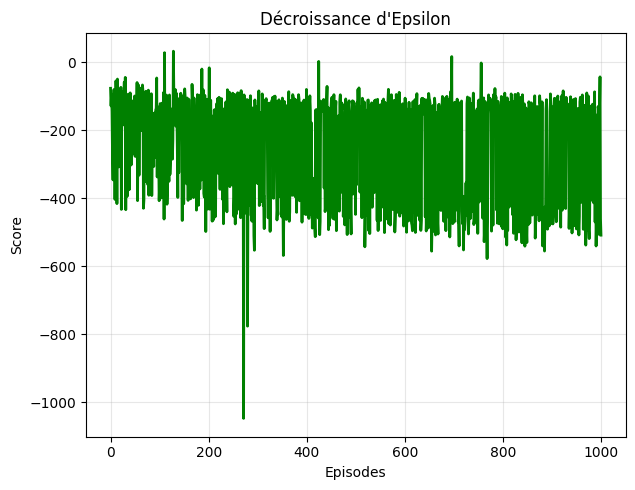

In [ ]:
#TODO

init_seed(42)

eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995


env = gym.make("LunarLander-v3")
env = RecordEpisodeStatistics(env)

agent = AgentSimple(dim_etat=env.observation_space.shape[0], 
                   dim_action=env.action_space.n)

n_episodes = 1000
scores = []
epsilons = []
episodes_list = []

epsilon = eps_start
for episode in range(n_episodes):
    epsilon = max(eps_end, eps_decay*epsilon)
    epsilons.append(epsilon)

    state, info = env.reset()
    done = False
    total_reward = 0
    truncated = False
    while not done and not truncated:
        action = agent.action_egreedy(state, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)

        state = next_state
        total_reward += reward
        done = terminated

    scores.append(total_reward)
    episodes_list.append(episode)
    if (episode+1) % 100 == 0:
        print(f"Episode {episode+1}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

env.close()

utils.plot_sumrwdperepi(scores)

# 5. Deep QLearning avec Replay Buffer

L'algorithme (sans r√©seau cible) est donn√© ci-dessous:

<img src='img/DQN2.png'  width=700px>


- La phase d'**√©chantillonage** est une phase d'interaction avec l'environnement (sans apprentissage), pendant laquelle l'agent stocke en m√©moire toutes les transitions rencontr√©es. Une transition est un tuple `(√©tat,action,√©tat_suivant,r√©compense,fin_episode)`. La m√©moire a une taille maximale; lorsqu‚Äôelle est d√©pass√©e, les nouvelles transitions remplacent les plus anciennes. 

- La phase d'**apprentissage** permet de mettre √† jour les param√®tres de la fonction *Q* √† partir de plusieurs (minibatch) transitions (64 par exemple) stock√©es dans la m√©moire. La phase d'apprentissage est r√©alis√©e tous les `t` pas (ou actions) dans l'environnement (par ex. $t=4$).

- La classe `ReplayBuffer` du fichier `replaybuffer.py` permet de stocker des transitions dans une m√©moire et de r√©cup√©rer des minibatch de transitions.


Vous devez impl√©menter l'algorithme du **Deep QLearning avec ReplayBuffer** donn√© ci-dessus.

Remarque: 
- vous n'utiliserez pas de r√©seau cible (*target network*) pour l'instant.
- Pour l'optimizer, SGD et [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) sont particuli√®rement adapt√©s. 
- Dans la phase d'apprentissage, les √©l√©ments r√©cup√©r√©s dans un minibatch  sont des tenseurs de taille $d \times dim\_element$. Vous devez dans cette phase faire des calculs tensoriel directement (et pas de boucle for sur $d$ !)
- Voici aussi des liens vers diff√©rentes fonctions de PyTorch qui pourraient vous √™tre utiles: [unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html), [gather](https://pytorch.org/docs/stable/generated/torch.gather.html)


> <span style="color:green">Compl√©ter la classe `AgentDQN`</span> 
>
> <span style="color:green">Impl√©menter l'algorithme dans la fonction *dqnalgo* ci-dessous.  </span> 
>
> <span style="color:green">Utiliser cet agent sur plusieurs √©pisodes dans l'environnement `LunarLander`. Vous proposerez un trac√© de la somme des r√©compenses obtenues par √©pisode (vous pouvez utiliser `utils.py`).</span> 


 
 

In [6]:
#Reload all modules every time before executing the Python code typed
%autoreload 2
from replaybuffer import ReplayBuffer
from agentdqn import AgentDQN
import torch.nn as nn
import numpy as np

In [ ]:
#TODO
T = 1000
LEARNSTEP = 4
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995
def dqnalgo(agent,env,nb_episodes,eps_start,eps_end,eps_decay):
    """
        Retourne la somme des recompenses par √©pisode
    """
    scores = []
    epsilons = []
    episodes_list = []

    epsilon = eps_start
    for episode in range(nb_episodes):
        epsilon = max(eps_end, eps_decay*epsilon)
        epsilons.append(epsilon)

        state, info = env.reset()
        done = False
        total_reward = 0
        truncated = False
        for t in range(1,T):
            action = agent.action_egreedy(state, epsilon)
            next_state, reward, terminated, truncated, info = env.step(action)

            agent.phase_echantillonage(state, action, reward, next_state, terminated)
            if t%LEARNSTEP == 0 and t>64:
                agent.phase_apprentissage()
            state = next_state
            total_reward += reward
            done = terminated
            if terminated or truncated:
                break
            
        scores.append(total_reward)
        episodes_list.append(episode)
        if (episode+1) % 100 == 0:
            print(f"Episode {episode+1}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")
            #env.render()
    env.close()
    return scores, epsilons, episodes_list


In [45]:
env = gym.make("LunarLander-v3")

#TOCOMPLETE
init_seed(42)
agent = AgentDQN(dim_etat=env.observation_space.shape[0], 
                   dim_action=env.action_space.n, gamma=0.99)
scores, epsilons, episodes_list = dqnalgo(agent,env,1000,eps_start,eps_end,eps_decay)


Episode 100, Total Reward: -75.25191026938712, Epsilon: 0.606
Episode 200, Total Reward: 88.09608637003717, Epsilon: 0.367
Episode 300, Total Reward: 303.91828176063495, Epsilon: 0.222
Episode 400, Total Reward: 203.28081727106456, Epsilon: 0.135
Episode 500, Total Reward: -55.997258424564, Epsilon: 0.082
Episode 600, Total Reward: 215.5019301814845, Epsilon: 0.049
Episode 700, Total Reward: -2.438052301703365, Epsilon: 0.030
Episode 800, Total Reward: -39.458260200450425, Epsilon: 0.018
Episode 900, Total Reward: -17.911725176554015, Epsilon: 0.011
Episode 1000, Total Reward: -47.65290797888031, Epsilon: 0.010


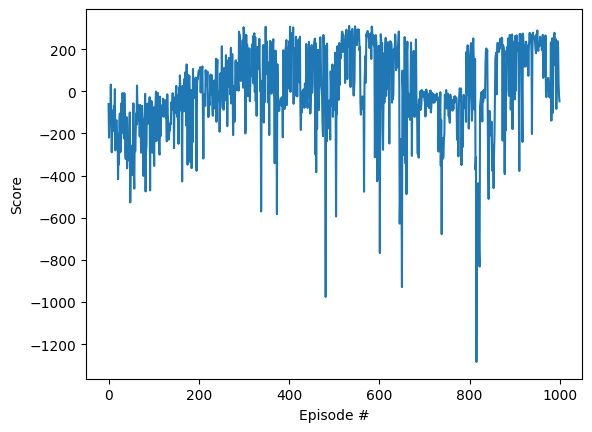

In [46]:
utils.plot_sumrwdperepi(scores)

> <span style="color:green">Faites maintenant une moyenne sur diff√©rents seed, avec un apprentissage par seed, et tracer le r√©sultat (somme des r√©compenses par √©pisodes) moyenn√© sur ces seed. Vous utiliserez `init_seed()` et pouvez utiliser `utils.py`.</span> </span> 

In [48]:
seeds = [42, 43, 44,45,46]
all_scores = []
for seed in seeds:
    init_seed(seed)
    env = gym.make("LunarLander-v3")
    agent = AgentDQN(dim_etat=env.observation_space.shape[0], 
                   dim_action=env.action_space.n, gamma=0.99)
    scores, epsilons, episodes_list = dqnalgo(agent,env,1000,eps_start,eps_end,eps_decay)
    all_scores.append(scores)
utils.plot_sumrwdperepi_overseed(all_scores)

Episode 100, Total Reward: -144.52628746961375, Epsilon: 0.606
Episode 200, Total Reward: 56.15350913019327, Epsilon: 0.367
Episode 300, Total Reward: -437.05754833489556, Epsilon: 0.222
Episode 400, Total Reward: -388.15302127517646, Epsilon: 0.135
Episode 500, Total Reward: -333.1671021664389, Epsilon: 0.082
Episode 600, Total Reward: -191.09770169745556, Epsilon: 0.049
Episode 700, Total Reward: -68.07288868182147, Epsilon: 0.030
Episode 800, Total Reward: -385.5721797149387, Epsilon: 0.018
Episode 900, Total Reward: -95.6773250592988, Epsilon: 0.011
Episode 1000, Total Reward: -113.74668254678778, Epsilon: 0.010
Episode 100, Total Reward: -98.33884667923368, Epsilon: 0.606
Episode 200, Total Reward: -328.5272234052611, Epsilon: 0.367
Episode 300, Total Reward: -154.01798979410714, Epsilon: 0.222
Episode 400, Total Reward: 188.3556798634587, Epsilon: 0.135
Episode 500, Total Reward: 230.04363964281205, Epsilon: 0.082
Episode 600, Total Reward: -83.14737034517393, Epsilon: 0.049
Epis

IndexError: invalid index to scalar variable.

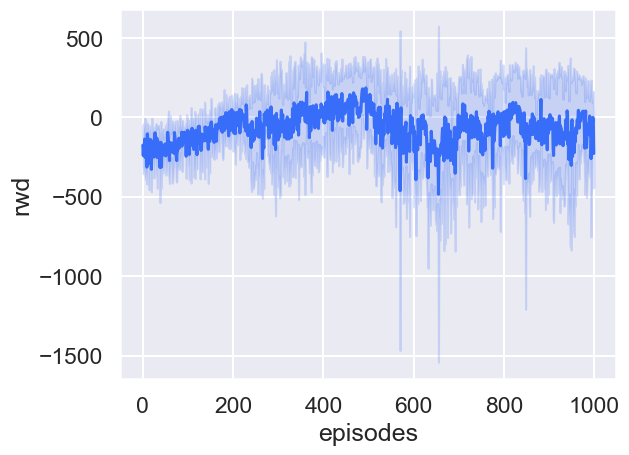

In [60]:
for i in range(len(all_scores)):
    all_scores[i] = [[r] for r in all_scores[i]]
utils.plot_sumrwdperepi_overseed(all_scores)

# 6. Deep QLearning avec r√©seau cible

Il se peut que votre agent pr√©c√©dent apprenne des comportements int√©ressants mais qu‚Äôils soient tr√®s instables. On va maintenant ajouter un r√©seau cible pour l'am√©liorer.

> <span style="color:green"> Quelle est la cause des instabilit√©s de l'algorithme pr√©c√©dent ? Pourquoi le r√©seau cible am√©liore ces instabilit√©s ?</span> 

> <span style="color:blue">Votre r√©ponse: </span>
L‚Äôinstabilit√© vient du fait que le m√™me r√©seau sert √† la fois pour pr√©dire les valeurs 
ùëÑ
Q et pour calculer les cibles lors de l‚Äôapprentissage. Comme les poids changent constamment, les cibles changent aussi, ce qui rend l‚Äôapprentissage instable.

Le r√©seau cible corrige ce probl√®me en introduisant un second r√©seau, mis √† jour moins fr√©quemment. Le r√©seau principal choisit les actions, tandis que le r√©seau cible fournit des cibles plus stables, ce qui rend l‚Äôapprentissage plus r√©gulier et facilite la convergence.

L'algorithme DQN (avec r√©seau cible) est donn√© ci-dessous:

<img src='img/DQNcible.png'  width=500px>


Le r√©seau cible sera mis √† jour toutes les N √©tapes d'apprentissage (500 par exemple si $t=4$) en recopiant enti√®rement le r√©seau de neurone original dans le duplicat.

Pour copier des poids d'un r√©seau de neurone vers un autre, la m√©thode `copy_` peut √™tre appel√©e sur les param√®tres:

`for param_duplicat, param_source in zip(model_duplicat.parameters(), model_source.parameters()):`
           
`param_duplicat.data.copy_(param_source.data)`

> <span style="color:green"> Compl√©ter la classe `AgentDQNCible` pour impl√©menter un agent apprenant avec DQN (deep QLearning et *target network*).</span> 






> <span style="color:green">Utiliser cet agent **dans l'algorithme dqnalgo pr√©c√©dent**. Vous proposerez un trac√© de la somme des r√©compenses obtenues par √©pisode sur plusieurs seed.</span> 

In [10]:
from agentdqncible import AgentDQNCible

In [11]:
# TODO

# 6. Sauvegarde d'un agent

> <span style="color:green"> Sauvegarder un agent qui a correctement appris dans un fichier 'monAgentDQN.pth'. Vous pr√©ciserez ci-dessous les hyperparam√®tres utilis√©s pour cet agent. </span> 



> <span style="color:blue">Hyperparam√®tres de l'agent: </span>

In [12]:
#Exemple de code pour sauvegarde d'un r√©seau
#savedfile = 'checkpoint.pth'
#torch.save(agent.network.state_dict(), savedfile)

#Exemple de code pour chargement d'un reseau sauvegarde
#state_dict = torch.load(savedfile)
#agent.network.load_state_dict(state_dict)

> <span style="color:green"> Proposer un code ci-dessous pour visualiser un √©pisode de cet agent en mode glouton. </span> 


In [13]:
env = gym.make("LunarLander-v3", render_mode="human")
#TODO 

> <span style="color:green"> Si vous avez test√© diff√©rents hyperparam√®tres, vous pouvez le pr√©ciser ci-dessous. </span> 

> <span style="color:blue">Hyperparam√®tres test√©s: </span>